# Capacitively Coupled CPBs

This notebook computes the Hamiltonian of the capacitively coupled cooper pair boxes circuit. 

<center><img src="images/circuit - capacitive CPBs.png" width=400 height=400/></center>

## Install and Import Required Packages

In [2]:
%%capture out
!pip install matplotlib
!pip install scipy
!pip install matplotlib
!pip install tdqm

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse.linalg
import scipy.sparse as sparse
import json

from tqdm import tqdm

## Initialise Constants

In [10]:
h = 6.626e-34
hbar = 1.055e-34
e_charge = 1.60218e-19
flux_quanta = h / (2 * e_charge)

## Construct System Class

In [11]:
class System:
    
    def __init__(self, EJ=121e9, CJ=8e-15, Cr=100e-15, Cc=5e-15, Lr=10e-9, alpha=0.4, ng=0.25, flux=0, ncut=2, mcut=20):
        self.h = 6.626e-34
        self.hbar = 1.055e-34
        self.e_charge = 1.60218e-19
        self.flux_quanta = self.h / (2 * self.e_charge)
        
        self.EJ = EJ * self.h                   # Josephson energy
        self.CJ = CJ                            # Josephson capacitance
        self.Cr = Cr                            # Resonator capacitance
        self.Cc = Cc                            # Coupling capacitance
        self.Lr = Lr                            # Resonator inductance
        self.alpha = alpha                      # Asymmetry of flux qubit
        self.ng = ng                            # Reduced gate charge
        self.flux = flux * self.flux_quanta     # Flux through qubit
        self.Z0 = np.sqrt(self.Lr / self.Cr)    # Impedance of resonator
        self.ncut = ncut                        # Cut-off threshold for number basis
        self.mcut = mcut                        # Cut-off threshold for resonator Fock states
        
        self.init_operators()
        
    def _print_params(self):
        print(f'EJ:    {self.EJ}')
        print(f'CJ:    {self.CJ}')
        print(f'Cr:    {self.Cr}')
        print(f'Cc:    {self.Cc}')
        print(f'Lr:    {self.Lr}')
        print(f'alpha: {self.alpha}')
        print(f'ng:    {self.ng}')
        print(f'flux:  {self.flux}')

    def init_operators(self):
        self.I_cb = np.diag(np.ones(2 * self.ncut + 1))   # Identity for qubit (charge basis)
        self.I_fb = np.diag(np.ones(self.mcut))           # Identity for resonator (Fock basis)
        
        self.q_op_cb = np.diag(2 * self.e_charge * np.arange(-self.ncut, self.ncut + 1, dtype=np.complex_))           # Charge operator (charge basis)
        self.ng_op_cb = 2 * self.e_charge * self.ng * self.I_cb
        self.e_iphi_op_cb = np.diag(np.ones(2 * self.ncut, dtype=np.complex_), k=1)                                   # e^{i \phi} operator (charge basis)
        self.creation_op_fb = np.diag(np.sqrt(np.arange(1, self.mcut, dtype=np.complex_)), k=-1)                      # Creation operator (Fock basis)
        self.annihilation_op_fb = np.conjugate(self.creation_op_fb.T)                                                 # Annihilation operator (Fock basis)
        self.q_op_fb = np.sqrt(self.hbar / (2 * self.Z0)) * 1j * (self.creation_op_fb - self.annihilation_op_fb)      # Charge operator (Fock basis)
        self.phi_op_fb = np.sqrt(self.hbar * self.Z0 * 0.5) * (self.creation_op_fb + self.annihilation_op_fb)         # Phi operator (Fock basis)
        
        self.q1_q1_qr = self.tensor4(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb, self.I_fb)
        self.q1_q2_qr = self.tensor4(self.q_op_cb, self.q_op_cb, self.I_cb, self.I_fb)
        self.q1_q3_qr = self.tensor4(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.I_fb)
        self.q1_q4_qr = self.tensor4(self.q_op_cb, self.I_cb, self.I_cb, self.q_op_fb)
        self.q2_q2_qr = self.tensor4(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_fb)
        self.q2_q3_qr = self.tensor4(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb, self.I_fb)
        self.q2_q4_qr = self.tensor4(self.I_cb, self.q_op_cb, self.I_cb, self.q_op_fb)
        self.q3_q3_qr = self.tensor4(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb), self.I_fb)
        self.q3_q4_qr = self.tensor4(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb, self.q_op_fb)
        self.q4_q4_qr = self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.q_op_fb @ self.q_op_fb)
        
        self.q1_q = self.tensor3(self.q_op_cb, self.I_cb, self.I_cb)
        self.q2_q = self.tensor3(self.I_cb, self.q_op_cb, self.I_cb)
        self.q3_q = self.tensor3(self.I_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        
        self.q1_q1_q = self.tensor3(self.q_op_cb @ self.q_op_cb, self.I_cb, self.I_cb)
        self.q1_q2_q = self.tensor3(self.q_op_cb, self.q_op_cb, self.I_cb)
        self.q1_q3_q = self.tensor3(self.q_op_cb, self.I_cb, self.q_op_cb + self.ng_op_cb)
        self.q2_q2_q = self.tensor3(self.I_cb, self.q_op_cb @ self.q_op_cb, self.I_cb)
        self.q2_q3_q = self.tensor3(self.I_cb, self.q_op_cb, self.q_op_cb + self.ng_op_cb)
        self.q3_q3_q = self.tensor3(self.I_cb, self.I_cb, (self.q_op_cb + self.ng_op_cb) @ (self.q_op_cb + self.ng_op_cb))
    
    def tensor3(self, op1, op2, op3):
        return np.kron(np.kron(op1, op2), op3)
    
    def tensor4(self, op1, op2, op3, op4):
        return np.kron(np.kron(np.kron(op1, op2), op3), op4)
    
    def hc(self, state):
        return np.conjugate(state).T
        
    def kin_qr(self):
        self.init_operators()

        Csum = self.Cr + self.Cc
        Cstar = (self.Cr * self.Cc) / self.CJ
        C0 = np.sqrt((1 + self.alpha) * (2 * self.alpha * self.CJ * Csum + (1 + self.alpha) * self.Cr * self.Cc))

        kin_q = (self.alpha * (2 + self.alpha) * Csum + (1 + self.alpha) * Cstar) * 0.5 * (self.q1_q1_qr + self.q2_q2_qr)
        kin_q += self.alpha**2 * Csum * self.q1_q2_qr
        kin_q += self.alpha * (1 + self.alpha) * Csum * (self.q1_q3_qr + self.q2_q3_qr)
        kin_q += (1 + self.alpha)**2 * Csum * 0.5 * self.q3_q3_qr
        kin_q += self.alpha * (1 + self.alpha) * self.Cc * (self.q1_q4_qr + self.q2_q4_qr)
        kin_q += (1 + self.alpha)**2 * self.Cc * self.q3_q4_qr
        kin_q += (1 + self.alpha) * (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc) * 0.5 * self.q4_q4_qr
        
        kin_q = kin_q / C0**2

        return kin_q

    def pot_qr(self):
        self.init_operators()
        
        pot_q = -self.EJ * 0.5 * self.tensor4(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb, self.I_fb)
        pot_q += -self.EJ * 0.5 * self.alpha * self.tensor4(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb, self.I_fb)
        pot_q += -self.EJ * 0.5 * self.alpha * self.tensor4(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T, self.I_fb)
        pot_q += -self.EJ * 0.5 * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T, self.I_fb)
        pot_q += -self.EJ * 0.5 * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor4(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb, self.I_fb)
        pot_q += -self.EJ * 0.5 * self.tensor4(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_fb)
        pot_q += self.EJ * 2 * (1 + self.alpha) * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.I_fb)
        pot_q += 0.5 * self.Lr**-1 * self.tensor4(self.I_cb, self.I_cb, self.I_cb, self.phi_op_fb @ self.phi_op_fb)
        
        return pot_q
        
    def kin_q(self):
        self.init_operators()
        
        denom = 2 * self.alpha * (1 + self.alpha)**2 * self.CJ**3

        kin_q = self.alpha * (2 + self.alpha) * self.CJ**2 * (self.q1_q1_q + self.q2_q2_q)
        kin_q += 2 * self.alpha**2 * self.CJ**2 * self.q1_q2_q
        kin_q += 2 * self.alpha * (1 + self.alpha) * self.CJ**2 * (self.q1_q3_q + self.q2_q3_q)
        kin_q += (1 + self.alpha)**2 * self.CJ**2 * self.q3_q3_q

        self.kin_q = kin_q / denom
        
        return kin_q

    def pot_q(self):
        self.init_operators()

        pot_q = -self.EJ * 0.5 * self.tensor3(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb, self.I_cb)
        pot_q += -self.EJ * 0.5 * self.alpha * self.tensor3(self.e_iphi_op_cb.T, self.I_cb, self.e_iphi_op_cb)
        pot_q += -self.EJ * 0.5 * self.alpha * self.tensor3(self.e_iphi_op_cb, self.I_cb, self.e_iphi_op_cb.T)
        pot_q += -self.EJ * 0.5 * self.alpha * np.exp(2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb, self.e_iphi_op_cb.T)
        pot_q += -self.EJ * 0.5 * self.alpha * np.exp(-2j * np.pi * self.flux) * self.tensor3(self.I_cb, self.e_iphi_op_cb.T, self.e_iphi_op_cb)
        pot_q += -self.EJ * 0.5 * self.tensor3(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb)
        pot_q += self.EJ * 2 * (1 + self.alpha) * self.tensor3(self.I_cb, self.I_cb, self.I_cb)
        
        return pot_q

    def get_H_qr(self):
        self.H_qr = self.kin_qr() + self.pot_qr()
        
        return self.H_qr

    def get_H_q(self):
        self.H_q = self.kin_q() + self.pot_q()
        
        return self.H_q
    
    def diagonalise_qr(self, update=False):
        if update:
            self.get_H_qr()
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()
        
        self.evals_qr, self.evecs_qr = sp.linalg.eigh(
            self.H_qr, eigvals=(0, 1), eigvals_only=False
        )

        self.evecs_qr = self.evecs_qr.T
        
        return self.evals_qr, self.evecs_qr
    
    def diagonalise_q(self, update=False):
        if update:
            self.get_H_q()
        else:
            try:
                self.H_q
            except AttributeError:
                self.get_H_q()
        
        self.evals_q, self.evecs_q = sp.linalg.eigh(
            self.H_q, eigvals=(0, 1), eigvals_only=False
        )

        self.evecs_q = self.evecs_q.T
        
        return self.evals_q, self.evecs_q
    
    def init_qubit_states(self, update=False):
        if update:
            self.diagonalise_q(update=True)
        else:
            try:
                self.evecs_q
            except AttributeError:
                self.diagonalise_q()

        self.qubit_0 = self.evecs_q[0]
        self.qubit_1 = self.evecs_q[1]
        self.qubit_m = 2**-0.5 * (self.qubit_0 - self.qubit_1)
        self.qubit_p = 2**-0.5 * (self.qubit_0 + self.qubit_1)
    
    def _plot_qubit_states(self):
        self.init_qubit_states(update=True)
        plt.plot(self.qubit_0)
        plt.show()
    
    def init_cavity_states(self):
        self.fock_0 = np.zeros((self.mcut,))
        self.fock_0[0] = 1

        self.fock_1 = np.zeros((self.mcut,))
        self.fock_1[1] = 1

        self.fock_m = 2**-0.5 * (self.fock_0 - self.fock_1)
        self.fock_p = 2**-0.5 * (self.fock_0 + self.fock_1)
        
    def init_prod_states(self, update=False):
        try:
            self.fock_0
        except AttributeError:
            self.init_cavity_states()

        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.qubit_0
            except AttributeError:
                self.init_qubit_states()

        self.ket_00 = np.kron(self.qubit_0, self.fock_0)
        self.ket_01 = np.kron(self.qubit_0, self.fock_1)
        self.ket_10 = np.kron(self.qubit_1, self.fock_0)
        self.ket_11 = np.kron(self.qubit_1, self.fock_1)
        self.ket_0m = np.kron(self.qubit_0, self.fock_m)
        self.ket_0p = np.kron(self.qubit_0, self.fock_p)
        self.ket_p1 = np.kron(self.qubit_p, self.fock_1)
        self.ket_m0 = np.kron(self.qubit_m, self.fock_0)
    
    def calc_g_parr(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_parr = 1j * self.hc(self.ket_p1) @ self.H_qr @ self.ket_m0
        
        return g_parr
    
    def calc_g_perp(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_perp = self.hc(self.ket_11) @ self.H_qr @ self.ket_00
        
        return g_perp
    
    def calc_delta(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        delta = 2 * self.hc(self.ket_00) @ self.H_qr @ self.ket_00
        
        return delta
    
    def calc_omega(self, update=False):
        if update:
            self.get_H_qr()
            self.init_prod_states(update=True)
        else:
            try:
                self.H_qr
            except AttributeError:
                self.get_H_qr()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        omega = self.hc(self.ket_01) @ self.H_qr @ self.ket_01 - 0.5 * self.calc_delta()
        
        return omega
    
    def calc_bil_omega(self):
        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        omega_exp = self.hbar / np.sqrt(self.Lr * Cr_renorm)
        
        return omega_exp
    
    def calc_bil_coupling(self, update=False):
        C0 = np.sqrt((1 + self.alpha) * (2 * self.alpha * self.CJ * (self.Cr + self.Cc) + (1 + self.alpha) * self.Cr * self.Cc))

        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        Zr_renorm = np.sqrt(self.Lr / Cr_renorm)
        coeff = np.sqrt(self.hbar / (2 * Zr_renorm))

        coupling_op = self.alpha * (1 + self.alpha) * (self.Cc / C0**2) * (self.q1_q + self.q2_q) + (1 + self.alpha)**2 * (self.Cc / C0**2) * self.q3_q

        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.qubit_0
            except AttributeError:
                self.init_qubit_states()

        g_parr_bil = coeff * (self.hc(self.qubit_p) @ coupling_op @ self.qubit_m)
        g_perp_bil = coeff * (self.hc(self.qubit_1) @ coupling_op @ self.qubit_0)
        
        return g_parr_bil, g_perp_bil

In [56]:
class SparseSystem:
    
    def __init__(self, EJ1=121e9, EJ2=121e9, CJ1=8e-15, CJ2=8e-15, C1=8e-15, C2=8e-15, Cc=5e-15, ng=0.25, flux=0.5, ncut=2, mcut=20):
        self.h = 6.626e-34
        self.hbar = 1.055e-34
        self.e_charge = 1.60218e-19
        self.flux_quanta = self.h / (2 * self.e_charge)
        
        self.EJ1 = EJ1 * self.h                 # Josephson energy of junction 1
        self.EJ2 = EJ2 * self.h                 # Josephson energy of junction 2
        self.CJ1 = CJ1                          # Josephson capacitance of junction 1
        self.CJ2 = CJ2                          # Josephson capacitance of junction 2
        self.C1 = C1                          # Capacitance of circuit 1 capacitor
        self.C2 = C2                          # Capacitance of circuit 2 capacitor
        self.Cc = Cc                            # Coupling capacitance
        self.ng = ng                            # Reduced gate charge
        self.flux = flux                        # Flux through qubit
        self.ncut = ncut                        # Cut-off threshold for number basis
        self.mcut = mcut                        # Cut-off threshold for resonator Fock states
        
        self.Z1 = ((8 * self.CJ1) / self.EJ1)**0.5
        self.Z2 = ((8 * self.CJ2) / self.EJ2)**0.5
        
        self.init_operators()
        
    def _print_params(self):
        print(f'EJ:    {self.EJ}')
        print(f'CJ:    {self.CJ}')
        print(f'Cr:    {self.Cr}')
        print(f'Cc:    {self.Cc}')
        print(f'Lr:    {self.Lr}')
        print(f'alpha: {self.alpha}')
        print(f'ng:    {self.ng}')
        print(f'flux:  {self.flux}')

    def init_operators(self):
        self.I_cb = sp.sparse.diags(np.ones(2 * self.ncut + 1))   # Identity for qubit (charge basis)
        self.I_fb = sp.sparse.diags(np.ones(self.mcut))           # Identity for resonator (Fock basis)
        
        self.q_op_cb = sp.sparse.diags(-2 * self.e_charge * np.arange(-self.ncut, self.ncut + 1, dtype=np.complex_))           # Charge operator (charge basis)
        self.ng_op_cb = -2 * self.e_charge * self.ng * self.I_cb
        self.e_iphi_op_cb = sp.sparse.diags(np.ones(2 * self.ncut, dtype=np.complex_), offsets=1)                                   # e^{i \phi} operator (charge basis)
        self.creation_op_fb = sp.sparse.diags(np.sqrt(np.arange(1, self.mcut, dtype=np.complex_)), offsets=-1)                      # Creation operator (Fock basis)
        self.annihilation_op_fb = np.conjugate(self.creation_op_fb.T)                                                 # Annihilation operator (Fock basis)
        self.q_op_fb_1 = ((-2 * self.e_charge * 1j) / (2 * self.Z1)**0.5) * (self.creation_op_fb - self.annihilation_op_fb)      # Charge operator (Fock basis)
        self.phi_op_fb_1 = (self.Z1 / 2)**0.5 * (self.creation_op_fb + self.annihilation_op_fb)         # Phi operator (Fock basis)
        self.q_op_fb_2 = ((-2 * self.e_charge * 1j) / (2 * self.Z2)**0.5) * (self.creation_op_fb - self.annihilation_op_fb)      # Charge operator (Fock basis)
        self.phi_op_fb_2 = (self.Z2 / 2)**0.5 * (self.creation_op_fb + self.annihilation_op_fb)         # Phi operator (Fock basis)
        
        self.q1_q1 = self.tensor2(self.q_op_cb @ self.q_op_cb, self.I_cb)
        self.q1_q2 = self.tensor2(self.q_op_cb, self.q_op_cb)
        self.q2_q2 = self.tensor2(self.I_cb, self.q_op_cb @ self.q_op_cb)
        
        self.q1_q = self.tensor2(self.q_op_cb, self.I_cb)
        self.q2_q = self.tensor2(self.I_cb, self.q_op_cb)
    
    def tensor2(self, op1, op2):
        return sparse.kron(op1, op2)
    
    def tensor3(self, op1, op2, op3):
        return sparse.kron(sparse.kron(op1, op2), op3)
    
    def tensor4(self, op1, op2, op3, op4):
        return sparse.kron(sparse.kron(sparse.kron(op1, op2), op3), op4)
    
    def hc(self, state):
        return np.conjugate(state).T
        
    def kin(self):
        self.init_operators()
        
        C_mat = [
            [self.CJ1 + self.C1 + self.Cc, -self.Cc],
            [-self.Cc, self.CJ2 + self.C2 + self.Cc]
        ]
        
        C_mat_in = np.linalg.inv(C_mat)

        kin_mat = C_mat_in[0][0] * self.q1_q1
        kin_mat += 2 * C_mat_in[0][1] * self.q1_q2
        kin_mat += C_mat_in[1][1] * self.q2_q2
        
        kin_mat *= 0.5

        return kin_mat

    def pot(self):
        self.init_operators()
        
        pot_mat = -self.EJ1 * 0.5 * self.tensor2(self.e_iphi_op_cb + self.e_iphi_op_cb.T, self.I_cb)
        pot_mat += -self.EJ2 * 0.5 * self.tensor2(self.I_cb, self.e_iphi_op_cb + self.e_iphi_op_cb.T)
        pot_mat += -(self.EJ1 + self.EJ2) * 0.5 * self.tensor2(self.I_cb, self.I_cb)
        
        return pot_mat
        
    def kin_q(self):
        self.init_operators()
        
        kin_mat = (0.5 / (self.CJ1 + self.C1 + self.Cc)) * (self.q_op_cb @ self.q_op_cb)

        return kin_mat

    def pot_q(self):
        self.init_operators()
        
        pot_mat = -self.EJ1 * 0.5 * (self.e_iphi_op_cb + self.e_iphi_op_cb.T)
        
        return pot_mat

    def get_H(self):
        self.H = self.kin() + self.pot()
        self.H.eliminate_zeros()
        
        return self.H

    def get_H_q(self):
        self.H_q = self.kin_q() + self.pot_q()
        
        return self.H_q
    
    def diagonalise(self, update=False):
        if update:
            self.get_H()
        else:
            try:
                self.H
            except AttributeError:
                self.get_H()
        
        evals, evecs = sparse.linalg.eigs(
            self.H, k=10, which='SR'
        )
        evecs = evecs.T
        
        args = np.argsort(evals)
        self.evals = evals[args]
        self.evecs = evecs[args]
        
        return self.evals, self.evecs
    
    def diagonalise_q(self, update=False):
        if update:
            self.get_H_q()
        else:
            try:
                self.H_q
            except AttributeError:
                self.get_H_q()
        
        evals_q, evecs_q = sparse.linalg.eigs(
            self.H_q, k=10, which='SR'
        )
        evecs = evecs.T
        
        args = np.argsort(evals)
        self.evals_q = evals_q[args]
        self.evecs_q = evecs_q[args]
        
        return self.evals_q, self.evecs_q
    
    def init_qubit_states(self, update=False):
        if update:
            self.diagonalise(update=True)
        else:
            try:
                self.evecs
            except AttributeError:
                self.diagonalise()

        self.qubit_0 = self.evecs[0]
        self.qubit_1 = self.evecs[1]
        self.qubit_m = 2**-0.5 * (self.qubit_0 - self.qubit_1)
        self.qubit_p = 2**-0.5 * (self.qubit_0 + self.qubit_1)
    
    def _plot_qubit_states(self):
        self.init_qubit_states(update=True)
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |0>, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_0))
        plt.plot(np.imag(self.qubit_0))
        plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |1>, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_1))
        plt.plot(np.imag(self.qubit_1))
        plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |+>, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_p))
        plt.plot(np.imag(self.qubit_p))
        plt.show()
        
        plt.figure(figsize=(10, 7))
        plt.title(f'Qubit State: |->, ng: {self.ng}', size=20)
        plt.plot(np.real(self.qubit_m))
        plt.plot(np.imag(self.qubit_m))
        plt.show()

    def init_prod_states(self, update=False):
        try:
            self.fock_0
        except AttributeError:
            self.init_cavity_states()

        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.qubit_0
            except AttributeError:
                self.init_qubit_states()

        self.ket_00 = np.kron(self.qubit_0, self.fock_0)
        self.ket_01 = np.kron(self.qubit_0, self.fock_1)
        self.ket_10 = np.kron(self.qubit_1, self.fock_0)
        self.ket_11 = np.kron(self.qubit_1, self.fock_1)
        self.ket_0m = np.kron(self.qubit_0, self.fock_m)
        self.ket_0p = np.kron(self.qubit_0, self.fock_p)
        self.ket_p1 = np.kron(self.qubit_p, self.fock_1)
        self.ket_m0 = np.kron(self.qubit_m, self.fock_0)
    
    def calc_g_parr(self, update=False):
        if update:
            self.get_H()
            self.init_prod_states(update=True)
        else:
            try:
                self.H
            except AttributeError:
                self.get_H()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_parr = 1j * self.hc(self.ket_p1) @ self.H @ self.ket_m0
        
        return g_parr
    
    def calc_g_perp(self, update=False):
        if update:
            self.get_H()
            self.init_prod_states(update=True)
        else:
            try:
                self.H
            except AttributeError:
                self.get_H()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        g_perp = self.hc(self.ket_11) @ self.H @ self.ket_00
        
        return g_perp
    
    def calc_delta(self, update=False):
        if update:
            self.get_H()
            self.init_prod_states(update=True)
        else:
            try:
                self.H
            except AttributeError:
                self.get_H()

            try:
                self.ket_p1
            except AttributeError:
                self.init_prod_states()
        
        delta = self.hc(self.ket_10) @ self.H @ self.ket_10 - self.hc(self.ket_00) @ self.H @ self.ket_00
        
        return delta
    
    def calc_bil_omega(self):
        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        omega_exp = self.hbar / np.sqrt(self.Lr * Cr_renorm)
        
        return omega_exp
    
    def calc_bil_coupling(self, update=False):
        C0 = np.sqrt((1 + self.alpha) * (2 * self.alpha * self.CJ * (self.Cr + self.Cc) + (1 + self.alpha) * self.Cr * self.Cc))

        Cr_renorm = (2 * self.alpha * self.CJ * (self.Cc + self.Cr) + (1 + self.alpha) * self.Cr * self.Cc) / (2 * self.alpha * self.CJ + (1 + self.alpha) * self.Cc)
        Zr_renorm = np.sqrt(self.Lr / Cr_renorm)
        coeff = np.sqrt(self.hbar / (2 * Zr_renorm))

        coupling_op = self.alpha * (1 + self.alpha) * (self.Cc / C0**2) * (self.q1_q + self.q2_q) + (1 + self.alpha)**2 * (self.Cc / C0**2) * self.q3_q

        if update:
            self.init_qubit_states(update=True)
        else:
            try:
                self.qubit_0
            except AttributeError:
                self.init_qubit_states()

        g_parr_bil = -1 * coeff * (self.hc(self.qubit_p) @ coupling_op @ self.qubit_m)
        g_perp_bil = coeff * (self.hc(self.qubit_1) @ coupling_op @ self.qubit_0)
        
        return g_parr_bil, g_perp_bil


## Visualise Hamiltonians

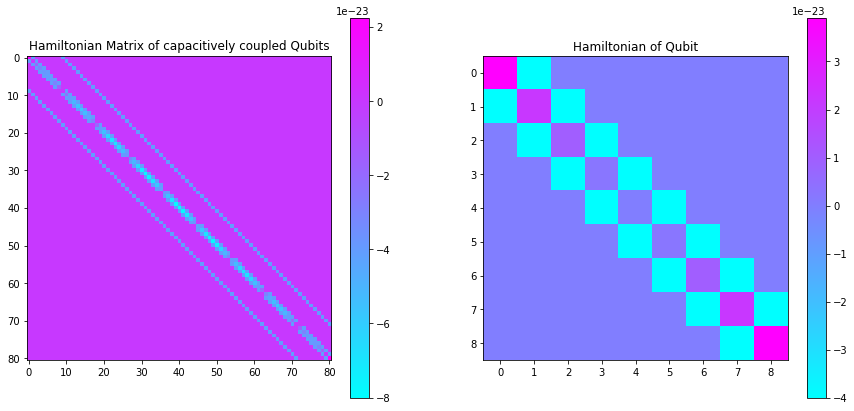

In [57]:
system = SparseSystem(ncut=4, mcut=2)

H = system.get_H()
H_q = system.get_H_q()

if type(H) == scipy.sparse.csr.csr_matrix:
    H = H.toarray()
    H_q = H_q.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Hamiltonian Matrix of capacitively coupled Qubits')
im1 = ax1.imshow(np.real(H), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Hamiltonian of Qubit')
im2 = ax2.imshow(np.real(H_q), cmap=plt.get_cmap('cool'))
f.colorbar(im2)

plt.show()

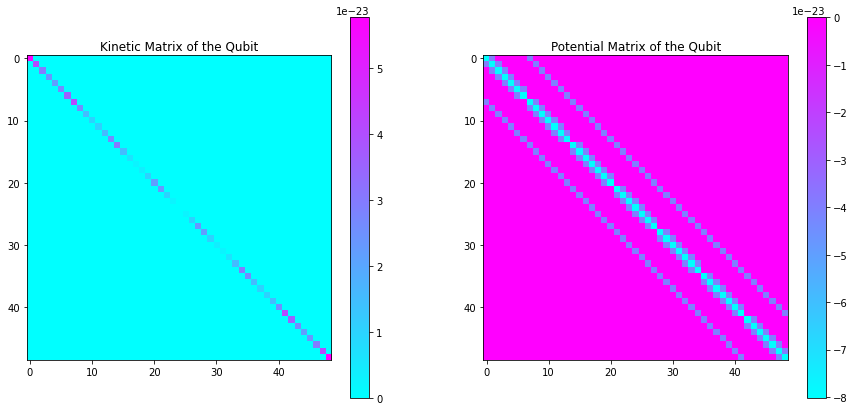

In [58]:
system = SparseSystem(ncut=3, mcut=2)

kin = system.kin()
pot = system.pot()

if type(kin) == scipy.sparse.csr.csr_matrix:
    kin = kin.toarray()
    pot = pot.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Qubit')
im1 = ax1.imshow(np.real(kin), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Qubit')
im2 = ax2.imshow(np.real(pot), cmap=plt.get_cmap('cool'))
f.colorbar(im2)
plt.show()

## Qubit Spectrum

In [37]:
evals_list = []
fluxes = np.linspace(0,1,100)

system = SparseSystem(ncut=6, Cc=0, ng=0)
for flux in tqdm(fluxes):
    system.flux = flux
    evals, evecs = system.diagonalise(update=True)
    evals_list.append(np.diff(evals[:5]))

evals = np.asarray(evals_list)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 75.05it/s]


/Users/daniellong/opt/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


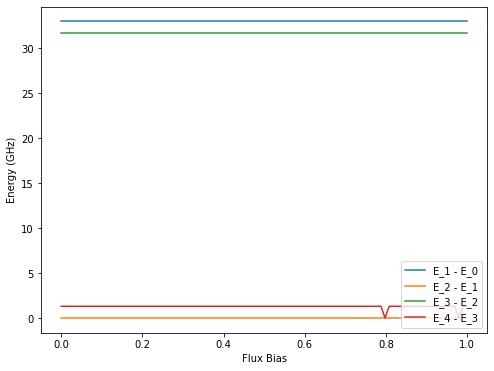

In [38]:
plt.figure(figsize=(8,6))
plt.plot(fluxes, (evals * 1e-9) / h)
plt.xlabel('Flux Bias')
plt.ylabel('Energy (GHz)')
plt.legend([f'E_{n+1} - E_{n}' for n in range(len(evals))], loc='lower right')
plt.show()

# Determine Approximate Hamiltonian Parameters

We assume that the Hamiltonian can be approximated by

\begin{equation}
    \mathcal{H} = \mu_1 \left( \frac{2 e^2}{Z_1} + \frac{3 E_{J1} Z_1}{4} - \frac{Z^2_1 E_{J1}}{4} \right) \sigma^{(1)}_z + \mu_2 \left( \frac{2 e^2}{Z_2} + \frac{3 E_{J2} Z_2}{4} - \frac{Z^2_2 E_{J2}}{4} \right) \sigma^{(2)}_z - \frac{C_c}{C_0} (\frac{-2 e^2}{\sqrt{Z_1 Z_2}}) \sigma^{(1)}_y \sigma^{(2)}_y
\end{equation}

\begin{equation}
    \mathcal{H} = \frac{\Delta_1}{2} \sigma^{(1)}_z + \frac{\Delta_2}{2} \sigma^{(2)}_z + g \sigma^{(1)}_y \sigma^{(2)}_y
\end{equation}

To find the parameters we calculate:

\begin{equation}
    \langle 1 | \langle 0 | H | 1 \rangle | 0 \rangle - \langle 0 | \langle 0 | H | 0 \rangle | 0 \rangle = \Delta_1
\end{equation}

\begin{equation}
    \langle 0 | \langle 1 | H | 0 \rangle | 1 \rangle - \langle 0 | \langle 0 | H | 0 \rangle | 0 \rangle = \Delta_2
\end{equation}

\begin{equation}
    \langle 1 | \langle 1 | H | 0 \rangle | 0 \rangle = i g_{\parallel}
\end{equation}

where we use the notation $| \text{Qubit} \rangle | \text{Cavity} \rangle$

In [62]:
sys = SparseSystem(ncut=6)

### Expected parameters

In [65]:
C1sum = sys.C1 + sys.CJ1 + sys.Cc
C2sum = sys.C2 + sys.CJ2 + sys.Cc
C0 = C1sum * C2sum - system.Cc**2

mu_1 = C1sum / (2 * C0)
mu_2 = C2sum / (2 * C0)

delta_1_exp = mu_1 * ( (2 * sys.e_charge**2) / sys.Z1 + (3 * sys.EJ1 * sys.Z1) / 4 - (sys.EJ1 * sys.Z1**2) / 4)
delta_2_exp = mu_2 * ( (2 * sys.e_charge**2) / sys.Z2 + (3 * sys.EJ2 * sys.Z2) / 4 - (sys.EJ2 * sys.Z2**2) / 4)

delta_1_exp

-0.40380327277555134

### Evaluate parameters

In [ ]:
delta_1_num, delta_2_num = sys.calc_deltas()
delta_1_num